###### **<span style="font-family: 'Palatino Linotype', serif;"> Espaços Normados </span>**

## **<span style="font-family: 'Palatino Linotype', serif;"> Violência e feminicídio no Brasil: Uma abordagem matemática </span>**

##### **<span style="font-family: 'Palatino Linotype', serif;"> Autores:</span>** <span style="font-family: 'Palatino Linotype', serif;"> Ana Luz P. Mendes, Caio M. Leão Dantas e Enzo J. Xavier</span> 
##### **<span style="font-family: 'Palatino Linotype', serif;"> Orientador:</span>** <span style="font-family: 'Palatino Linotype', serif;"> Vinicius Francisco Wasques </span> 

___

## 1. Importação de Bibliotecas e Configuração

Nesta seção, importamos as bibliotecas essenciais para manipulação de dados (`pandas`, `numpy`) e visualização gráfica (`matplotlib`, `seaborn`). Também incluímos módulos específicos para aprendizado de máquina (`sklearn`) e clusterização hierárquica (`scipy`), que serão fundamentais para o cálculo de distâncias e geração dos dendrogramas.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi 

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import cophenet, dendrogram, fcluster
from sklearn.decomposition import PCA

import geopandas as gpd
import unicodedata

SEMENTE_ALEATORIA = 8

## 2. Carregamento e Limpeza dos Dados

Realizamos aqui a leitura do conjunto de dados. O pré-processamento envolve a renomeação das colunas para termos técnicos mais acessíveis e a limpeza de caracteres indesejados (como `...` ou `-`), convertendo todas as entradas numéricas para seu formato adequado.

In [2]:
novas_colunas = [
    'UF', 'Feminicidio', 'Feminicidio_MPU_Ativa', 'Tentativa_Feminicidio',
    'Lesao_Corporal', 'Ameaca', 'Stalking', 'Violencia_Psicologica',
    'Chamadas_190', 'Feminicidio_Suicidio_Autor', 
    'MPU_Distribuidas', 'MPU_Concedidas', 'Descumprimento_MPU',
    'Estupro_Total', 'Assedio_Sexual', 'Importunacao_Sexual',
    'Estupro_Mulheres', 'Divulgacao_Pornografia', 'Exploracao_Sexual',
    'Tentativa_Estupro', 'Pericias_Vivos', 'Pericias_Cadaveres'
]

In [3]:
df_raw = pd.read_excel('Violência_contra_Mulher.xlsx')
df = df_raw.iloc[2:, :].copy() 

try:
    df.columns = novas_colunas
except ValueError:
    df.columns = novas_colunas + [f'Extra_{i}' for i in range(df.shape[1] - len(novas_colunas))]

df.reset_index(drop=True, inplace=True)

cols_numericas = df.columns.drop('UF')
for col in cols_numericas:
    df[col] = df[col].astype(str)
    df[col] = df[col].str.replace('...', '0', regex=False)
    df[col] = df[col].str.replace('-', '0', regex=False)
    df[col] = df[col].str.replace('.', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

display(df.head())

,UF,Feminicidio,Feminicidio_MPU_Ativa,Tentativa_Feminicidio,Lesao_Corporal,Ameaca,Stalking,Violencia_Psicologica,Chamadas_190,Feminicidio_Suicidio_Autor,...,Descumprimento_MPU,Estupro_Total,Assedio_Sexual,Importunacao_Sexual,Estupro_Mulheres,Divulgacao_Pornografia,Exploracao_Sexual,Tentativa_Estupro,Pericias_Vivos,Pericias_Cadaveres
0,Acre,80,1,520,14050,25480,1550,3060,19603,0,...,519,9910,520,1670,8600,37,40,53,397,4
1,Alagoas,220,1,750,26870,86610,6810,5740,14834,5,...,721,13920,850,3670,11690,87,210,82,1146,32
2,Amapá,20,0,550,6600,62680,12800,4930,4016,0,...,494,7990,1120,2400,7150,59,30,68,0,0
3,Amazonas,290,0,1070,49670,188580,21550,41710,8936,0,...,1261,15510,1130,7810,13530,166,20,133,1703,322
4,Bahia,1110,0,2500,139950,623200,35280,29240,32546,0,...,3784,53230,5580,18170,46330,455,170,389,3830,111


## 3. Padronização e Cálculo de Taxas

Para garantir uma comparação justa entre estados com populações distintas, normalizamos os dados calculando a taxa de ocorrências por 100 mil habitantes. Em seguida, aplicamos a padronização Z-Score (`StandardScaler`), transformando os dados para que tenham média 0 e desvio padrão 1.

In [4]:
populacao = {
    'Acre': 880631, 'Alagoas': 3220104, 'Amapá': 802837, 'Amazonas': 4281209,
    'Bahia': 14850513, 'Ceará': 9233656, 'Distrito Federal': 2982818,
    'Espírito Santo': 4102129, 'Goiás': 7350483, 'Maranhão': 7010960,
    'Mato Grosso': 3836399, 'Mato Grosso do Sul': 2901895, 'Minas Gerais': 21322691,
    'Pará': 8664306, 'Paraíba': 4145040, 'Paraná': 11824665, 'Pernambuco': 9539029,
    'Piauí': 3375646, 'Rio de Janeiro': 17219679, 'Rio Grande do Norte': 3446071,
    'Rio Grande do Sul': 11229915, 'Rondônia': 1746227, 'Roraima': 716793,
    'Santa Catarina': 8058441, 'São Paulo': 45973194, 'Sergipe': 2291077, 'Tocantins': 1577342
}

In [5]:
df_taxas = df.copy()
if 'UF' not in df_taxas.columns:
    df_taxas['UF'] = df_taxas.index 

cols_numericas = df_taxas.select_dtypes(include=[np.number]).columns
for col in cols_numericas:
    df_taxas[col] = df_taxas.apply(lambda x: (x[col] / populacao.get(x['UF'], 1)) * 100000, axis=1)

if 'UF' in df_taxas.columns:
    df_taxas.set_index('UF', inplace=True)

# dados com as taxas por 100.000 habitantes
df_taxas.head()

,Feminicidio,Feminicidio_MPU_Ativa,Tentativa_Feminicidio,Lesao_Corporal,Ameaca,Stalking,Violencia_Psicologica,Chamadas_190,Feminicidio_Suicidio_Autor,MPU_Distribuidas,...,Descumprimento_MPU,Estupro_Total,Assedio_Sexual,Importunacao_Sexual,Estupro_Mulheres,Divulgacao_Pornografia,Exploracao_Sexual,Tentativa_Estupro,Pericias_Vivos,Pericias_Cadaveres
UF,,,,,,,,,,,,,,,,,,,,,
Acre,9.084395,0.113555,59.048569,1595.446901,2893.379861,176.010156,347.478115,2226.017481,0.000000,504.183932,...,58.935014,1125.329451,59.048569,189.636749,976.572480,4.201533,4.542198,6.018412,45.081311,0.454220
Alagoas,6.832077,0.031055,23.291173,834.445099,2689.664682,211.483853,178.255112,460.668351,0.155274,144.777933,...,22.390581,432.284175,26.396663,113.971474,363.031753,2.701776,6.521528,2.546502,35.588913,0.993757
Amapá,2.491166,0.000000,68.507057,822.084682,7807.313315,1594.346050,614.072346,500.226073,0.000000,526.756988,...,61.531793,995.220699,139.505279,298.939884,890.591739,7.348939,3.736749,8.469963,0.000000,0.000000
Amazonas,6.773787,0.000000,24.992940,1160.186293,4404.830505,503.362485,974.257505,208.726086,0.000000,370.689681,...,29.454297,362.280842,26.394413,182.425105,316.032224,3.877409,0.467158,3.106599,39.778483,7.521240
Bahia,7.474489,0.000000,16.834435,942.391687,4196.488027,237.567551,196.895555,219.157412,0.000000,192.619608,...,25.480601,358.438796,37.574460,122.352676,311.975755,3.063867,1.144742,2.619438,25.790355,0.747449


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_taxas)

## 4. Análise Exploratória de Distâncias
Antes de aplicar os algoritmos de agrupamento, visualizamos as distâncias par-a-par entre os estados utilizando diferentes métricas (Manhattan, Euclidiana e Minkowski). As matrizes de distância (Heatmaps) abaixo nos permitem antecipar visualmente se os dados possuem estruturas naturais de agrupamento e como a escolha da métrica altera a percepção de "proximidade" entre os estados.

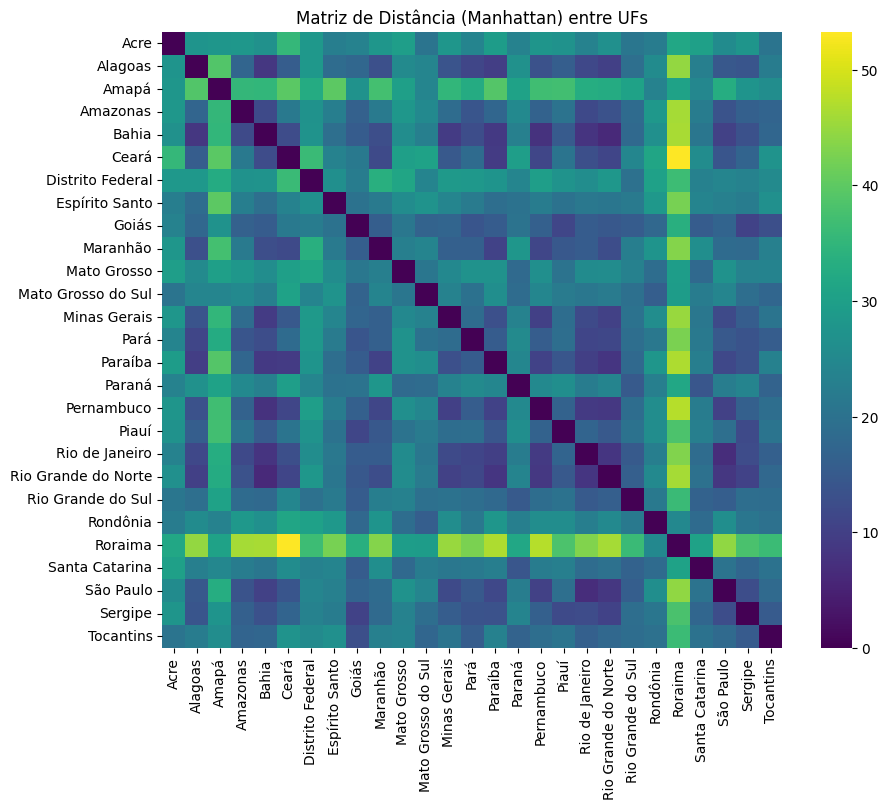

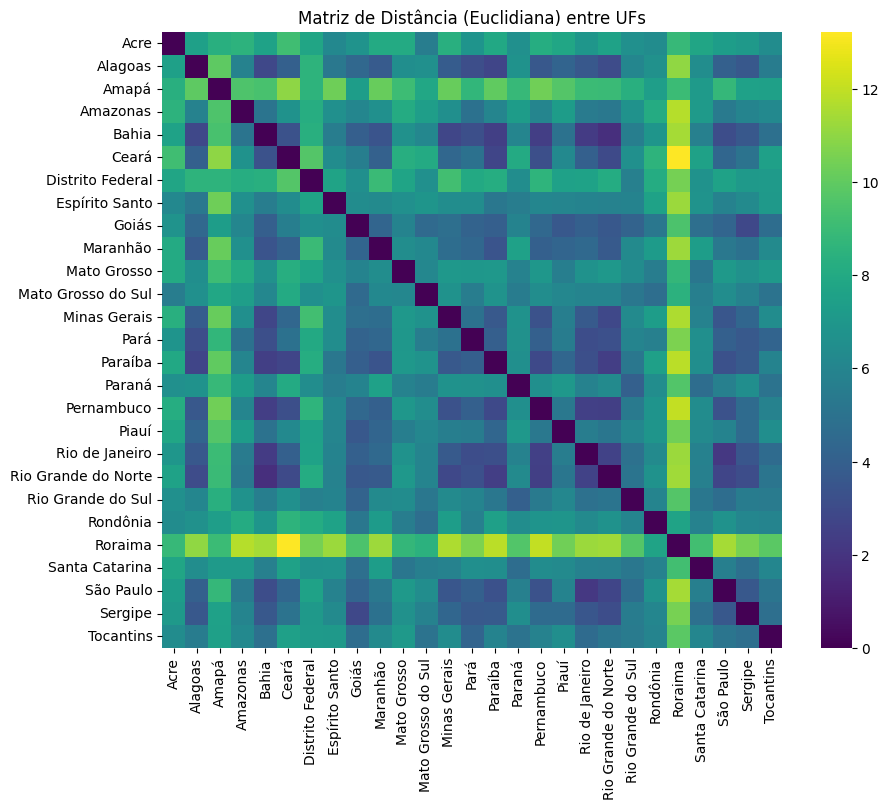

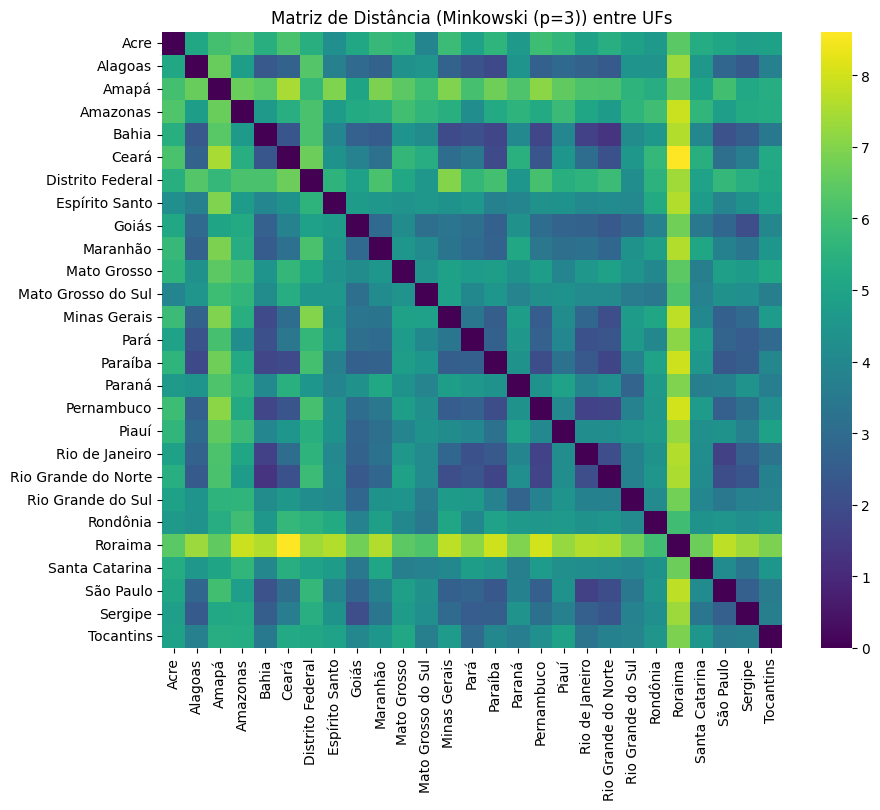

In [7]:
metricas = [
    ('cityblock', None),
    ('euclidean', None),
    ('minkowski', 3),
]

nomes = ['Manhattan', 'Euclidiana', 'Minkowski (p=3)']

from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

def distance_matrix(X, metrica, p=None):
    if metrica == 'minkowski' and p is not None:
        dist = pdist(X, metric=metrica, p=p)
    else:
        dist = pdist(X, metric=metrica)
    return squareform(dist)


i = -1
for metrica, p in metricas:
    i +=1
    distance_matrix_values = distance_matrix(X_scaled, metrica, p)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix_values,
                xticklabels=df_taxas.index,
                yticklabels=df_taxas.index,
                cmap='viridis')
    plt.title(f'Matriz de Distância ({nomes[i]}) entre UFs')
    plt.show()


## 5. Análise de Clusterização e Seleção de Modelo

Nesta etapa, investigamos diferentes métricas de distância (Manhattan, Euclidiana e Minkowski) para determinar qual delas melhor captura a geografia cultural da violência no Brasil. Utilizamos o Índice Rand Ajustado (ARI) para comparar os clusters gerados com as regiões geográficas reais (Norte, Sul, etc.), além do Coeficiente de Silhueta para validar a consistência interna dos grupos.

In [8]:
regioes_map = {
    'Acre': 'Norte', 'Amapá': 'Norte', 'Amazonas': 'Norte', 'Pará': 'Norte', 
    'Rondônia': 'Norte', 'Roraima': 'Norte', 'Tocantins': 'Norte',
    'Alagoas': 'Nordeste', 'Bahia': 'Nordeste', 'Ceará': 'Nordeste', 
    'Maranhão': 'Nordeste', 'Paraíba': 'Nordeste', 'Pernambuco': 'Nordeste', 
    'Piauí': 'Nordeste', 'Rio Grande do Norte': 'Nordeste', 'Sergipe': 'Nordeste',
    'Distrito Federal': 'Centro-Oeste', 'Goiás': 'Centro-Oeste', 
    'Mato Grosso': 'Centro-Oeste', 'Mato Grosso do Sul': 'Centro-Oeste',
    'Espírito Santo': 'Sudeste', 'Minas Gerais': 'Sudeste', 
    'Rio de Janeiro': 'Sudeste', 'São Paulo': 'Sudeste',
    'Paraná': 'Sul', 'Rio Grande do Sul': 'Sul', 'Santa Catarina': 'Sul'
}

labels_reais = [regioes_map.get(uf, 'Outro') for uf in df_taxas.index]

In [9]:
metricas = {
    'Manhattan (l=1)': {'metric': 'cityblock', 'p': 1}, 
    'Euclidiana (l=2)': {'metric': 'euclidean', 'p': 2},
    'Minkowski (l=3)': {'metric': 'minkowski', 'p': 3} 
}

melhor_modelo = {'ari': -1, 'nome': ''}

In [10]:
for nome, config in metricas.items():

    if config['metric'] == 'minkowski':
        dist_condensada = pdist(X_scaled, metric='minkowski', p=config['p'])
    else:
        dist_condensada = pdist(X_scaled, metric=config['metric'])
        
    Z_linkage = shc.linkage(dist_condensada, method='complete')
    c, coph_dists = cophenet(Z_linkage, dist_condensada)
    labels_preditos = fcluster(Z_linkage, t=5, criterion='maxclust')
    ari = adjusted_rand_score(labels_reais, labels_preditos)
    dist_quadrada = squareform(dist_condensada) # Para Silhueta, precisamos converter a distância condensada em matriz quadrada
    sil = silhouette_score(dist_quadrada, labels_preditos, metric="precomputed")
    print(f"{nome:<20} | {ari:.4f}          | {sil:.4f}        | {c:.4f}")
    
    if ari > melhor_modelo['ari']:
        melhor_modelo = {
            'ari': ari, 'nome': nome, 'linkage': Z_linkage, 
            'labels': labels_preditos, 'df': df_taxas
        }

print()
print(f"CONCLUSÃO: A métrica **{melhor_modelo['nome']}** capturou melhor a geografia.")

Manhattan (l=1)      | 0.2307          | 0.2399        | 0.8416
Euclidiana (l=2)     | 0.2500          | 0.1372        | 0.7630
Minkowski (l=3)      | 0.1728          | 0.1990        | 0.8020

CONCLUSÃO: A métrica **Euclidiana (l=2)** capturou melhor a geografia.


## 6. Dendrograma
O dendrograma abaixo ilustra a hierarquia de formação dos clusters utilizando a melhor métrica encontrada. A altura das ligações (eixo Y) representa a distância entre os grupos no momento da fusão, permitindo visualizar a proximidade estatística entre os estados.

Manhattan (l=1)      | ARI: 0.2307 | Silhueta: 0.2399 | Cofenético: 0.8416


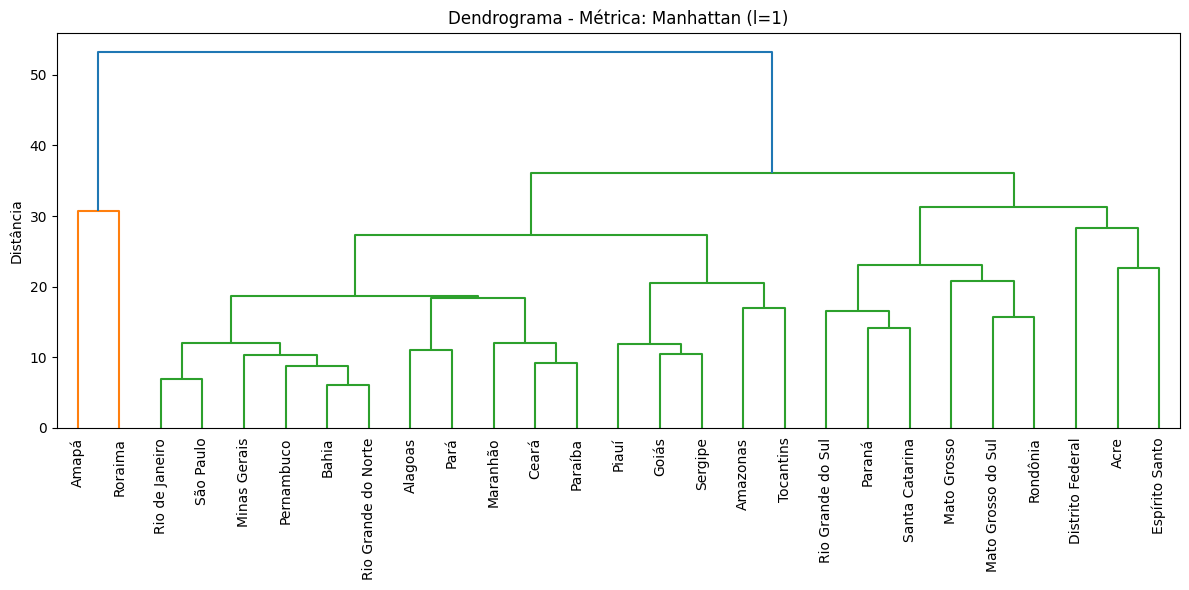

Euclidiana (l=2)     | ARI: 0.2500 | Silhueta: 0.1372 | Cofenético: 0.7630


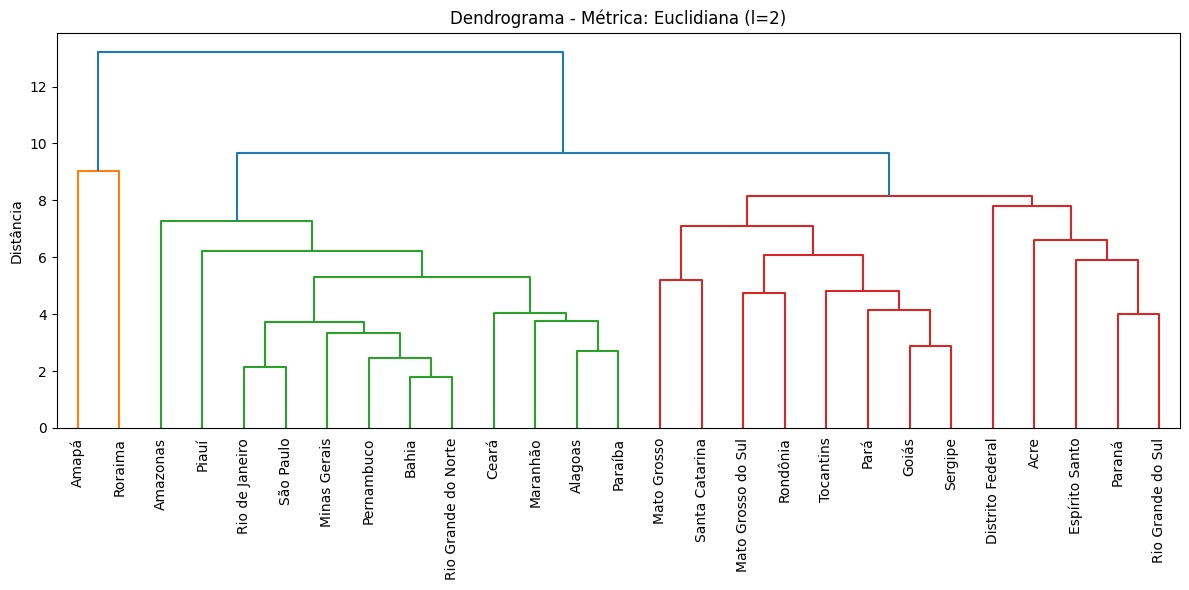

Minkowski (l=3)      | ARI: 0.1728 | Silhueta: 0.1990 | Cofenético: 0.8020


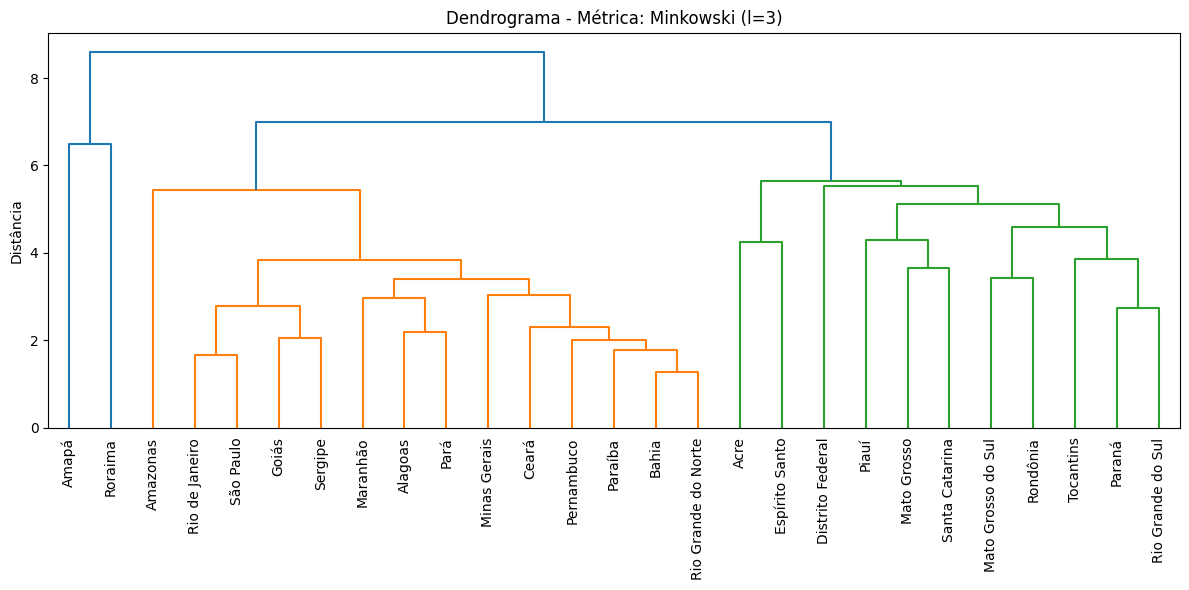


CONCLUSÃO: A métrica **Euclidiana (l=2)** capturou melhor a geografia.


In [11]:
melhor_modelo = {'ari': -1, 'nome': ''}

labels_estados = df_taxas.index.tolist() 

for nome, config in metricas.items():

    if config['metric'] == 'minkowski':
        dist_condensada = pdist(X_scaled, metric='minkowski', p=config['p'])
    else:
        dist_condensada = pdist(X_scaled, metric=config['metric'])
        
    Z_linkage = shc.linkage(dist_condensada, method='complete')
    labels_preditos = fcluster(Z_linkage, t=5, criterion='maxclust')
    ari = adjusted_rand_score(labels_reais, labels_preditos)
    c, coph_dists = cophenet(Z_linkage, dist_condensada)
    dist_quadrada = squareform(dist_condensada) 
    sil = silhouette_score(dist_quadrada, labels_preditos, metric="precomputed")
    
    print(f"{nome:<20} | ARI: {ari:.4f} | Silhueta: {sil:.4f} | Cofenético: {c:.4f}")

    plt.figure(figsize=(12, 6)) 
    plt.title(f"Dendrograma - Métrica: {nome}")
    plt.ylabel("Distância")
    
    dendrogram(
        Z_linkage,
        labels=labels_estados,
        leaf_rotation=90.,
        leaf_font_size=10.,
        show_contracted=True
        )
    
    plt.tight_layout() 
    plt.show() 


    if ari > melhor_modelo['ari']:
        melhor_modelo = {
            'ari': ari, 'nome': nome, 'linkage': Z_linkage, 
            'labels': labels_preditos
        }

print()
print(f"CONCLUSÃO: A métrica **{melhor_modelo['nome']}** capturou melhor a geografia.")

## 7. Distribuição Geoespacial dos Clusters
Abaixo, projetamos os clusters encontrados no mapa do Brasil. Esta etapa é fundamental para confirmar visualmente se os agrupamentos matemáticos correspondem a padrões regionais contíguos ou se há estados isolados (outliers) que destoam de seus vizinhos geográficos.

Carregando arquivo GeoJSON do Brasil (aguarde)...
Mapa base carregado e pronto.

--- Iniciando Iterações de Métricas ---
Métrica              | ARI        | Silhueta  
----------------------------------------------
Manhattan (l=1)      | 0.2307     | 0.2399


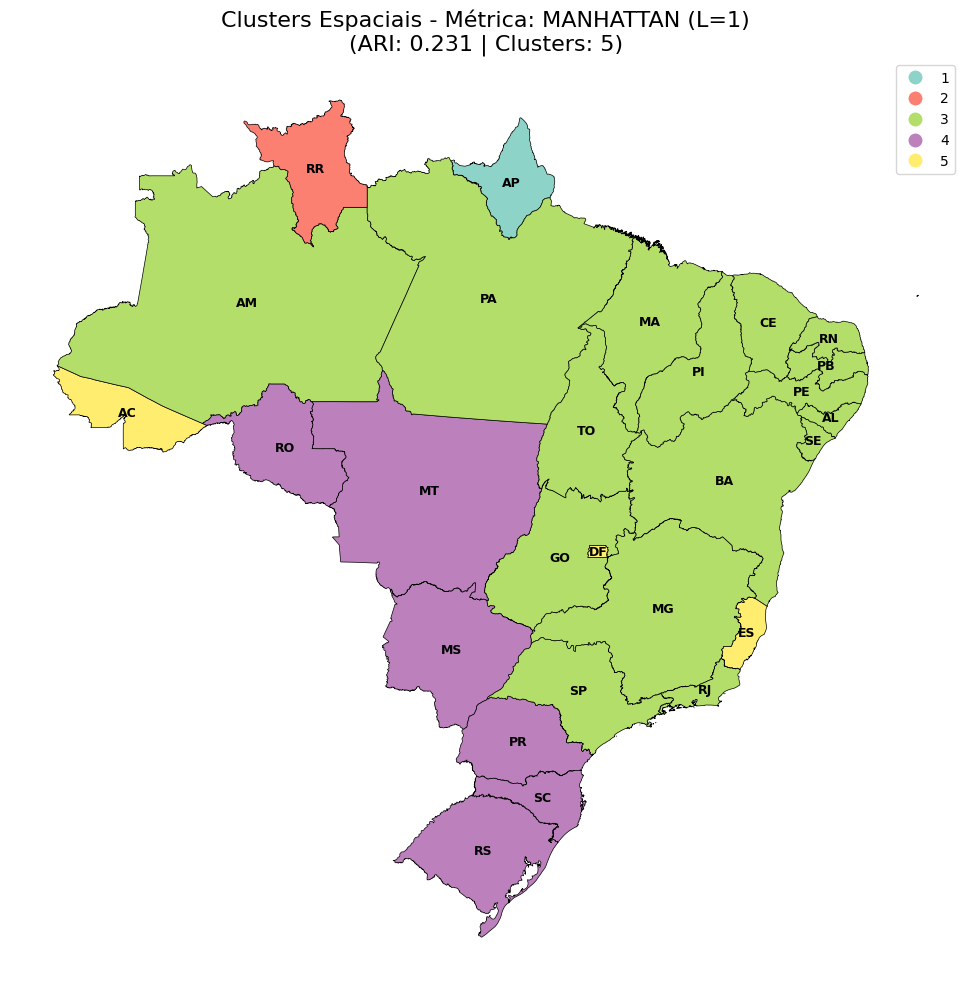

Euclidiana (l=2)     | 0.2500     | 0.1372


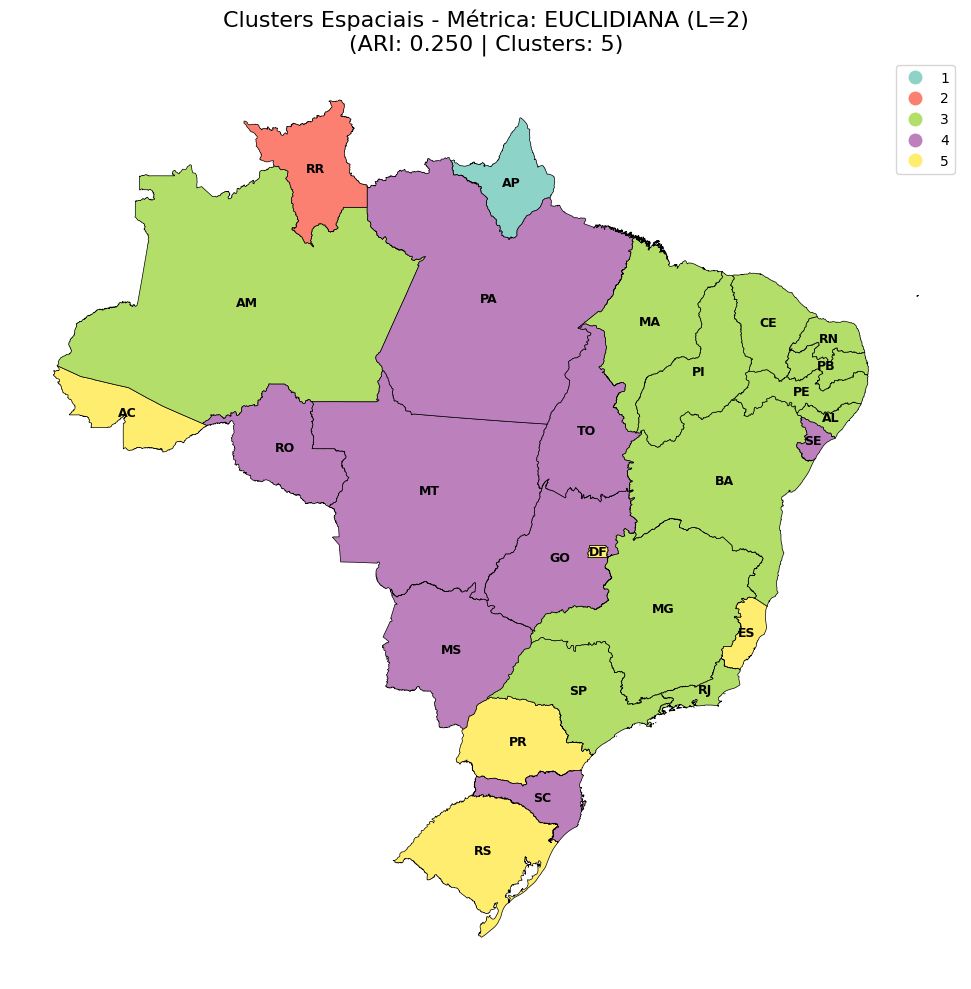

Minkowski (l=3)      | 0.1728     | 0.1990


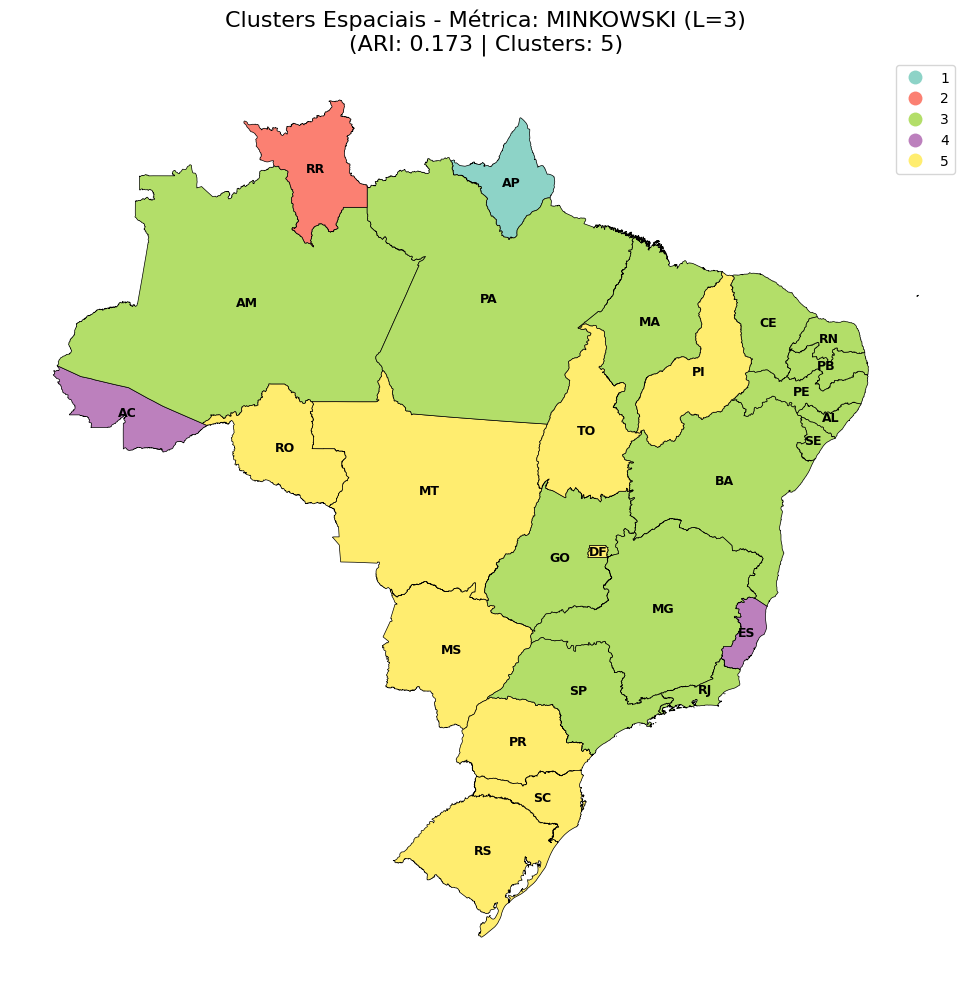

In [12]:
metricas = {
    'Manhattan (l=1)': {'metric': 'cityblock', 'p': 1}, 
    'Euclidiana (l=2)': {'metric': 'euclidean', 'p': 2},
    'Minkowski (l=3)': {'metric': 'minkowski', 'p': 3} 
}

def normalizar_nome(texto):
    if not isinstance(texto, str): return str(texto)
    return ''.join(c for c in unicodedata.normalize('NFD', texto)
                   if unicodedata.category(c) != 'Mn').upper().strip()

url_brasil = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"

try:
    print("Carregando arquivo GeoJSON do Brasil (aguarde)...")
    brasil_mapa_base = gpd.read_file(url_brasil)
    brasil_mapa_base['chave_merge'] = brasil_mapa_base['name'].apply(normalizar_nome)
    print("Mapa base carregado e pronto.")

except Exception as e:
    print(f"ERRO CRÍTICO ao carregar mapa: {e}")
    print("Verifique conexão ou instalação do 'geopandas'. O código parará.")
    # Em um script real, você poderia usar 'exit()' aqui, mas no notebook vamos apenas parar.
    brasil_mapa_base = None

if brasil_mapa_base is not None:
    
    melhor_modelo = {'ari': -1, 'nome': 'Nenhum'}
    print("\n--- Iniciando Iterações de Métricas ---")
    print(f"{'Métrica':<20} | {'ARI':<10} | {'Silhueta':<10}")
    print("-" * 46)

    for nome, config in metricas.items():

        if config['metric'] == 'minkowski':
            dist_condensada = pdist(X_scaled, metric='minkowski', p=config['p'])
        else:
            dist_condensada = pdist(X_scaled, metric=config['metric'])
            
        Z_linkage = shc.linkage(dist_condensada, method='complete')
        labels_preditos_atuais = fcluster(Z_linkage, t=5, criterion='maxclust')
        
        ari = adjusted_rand_score(labels_reais, labels_preditos_atuais)
        
        dist_quadrada = squareform(dist_condensada)
        sil = silhouette_score(dist_quadrada, labels_preditos_atuais, metric="precomputed")
        print(f"{nome:<20} | {ari:.4f}     | {sil:.4f}")


        try:
            df_cluster_atual = pd.DataFrame({
                'UF_Original': df_taxas.index,
                'Cluster': labels_preditos_atuais # Usando os labels ATUAIS
            })
            df_cluster_atual['chave_merge'] = df_cluster_atual['UF_Original'].apply(normalizar_nome)

            mapa_plot = brasil_mapa_base.copy().merge(df_cluster_atual, on='chave_merge', how='left')

            fig, ax = plt.subplots(1, 1, figsize=(12, 10))
            
            mapa_plot.plot(
                column='Cluster',
                ax=ax,
                legend=True,
                categorical=True,
                cmap='Set3',
                edgecolor='black',
                linewidth=0.5,
                missing_kwds={'color': 'lightgrey', 'label': 'Sem dados/Erro nome'}
            )
            
            for idx, row in mapa_plot.iterrows():
                if row['geometry'] and pd.notnull(row['Cluster']):
                    txt = row['sigla'] if 'sigla' in row else row['name'][:3].upper()
                    plt.annotate(text=txt, 
                                 xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                                 horizontalalignment='center', 
                                 verticalalignment='center',
                                 fontsize=9, color='black', fontweight='bold')

            plt.title(f"Clusters Espaciais - Métrica: {nome.upper()}\n(ARI: {ari:.3f} | Clusters: 5)", fontsize=16)
            plt.axis('off')
            plt.tight_layout()
            plt.show() 

        except Exception as e:
            print(f"Erro ao gerar mapa para a métrica {nome}: {e}")

        if ari > melhor_modelo['ari']:
            melhor_modelo = {
                'ari': ari, 'nome': nome, 'linkage': Z_linkage, 
                'labels': labels_preditos_atuais # Guarda os labels vencedores
            }

## 8. Análise de Perfil (Radar Chart)
Para interpretar o significado de cada cluster, geramos um gráfico de radar (Spider Plot). Os dados são normalizados entre 0 e 1 para visualização. Isso nos permite identificar, por exemplo, grupos caracterizados por alta violência física versus grupos com alta incidência de violência psicológica ou institucional.

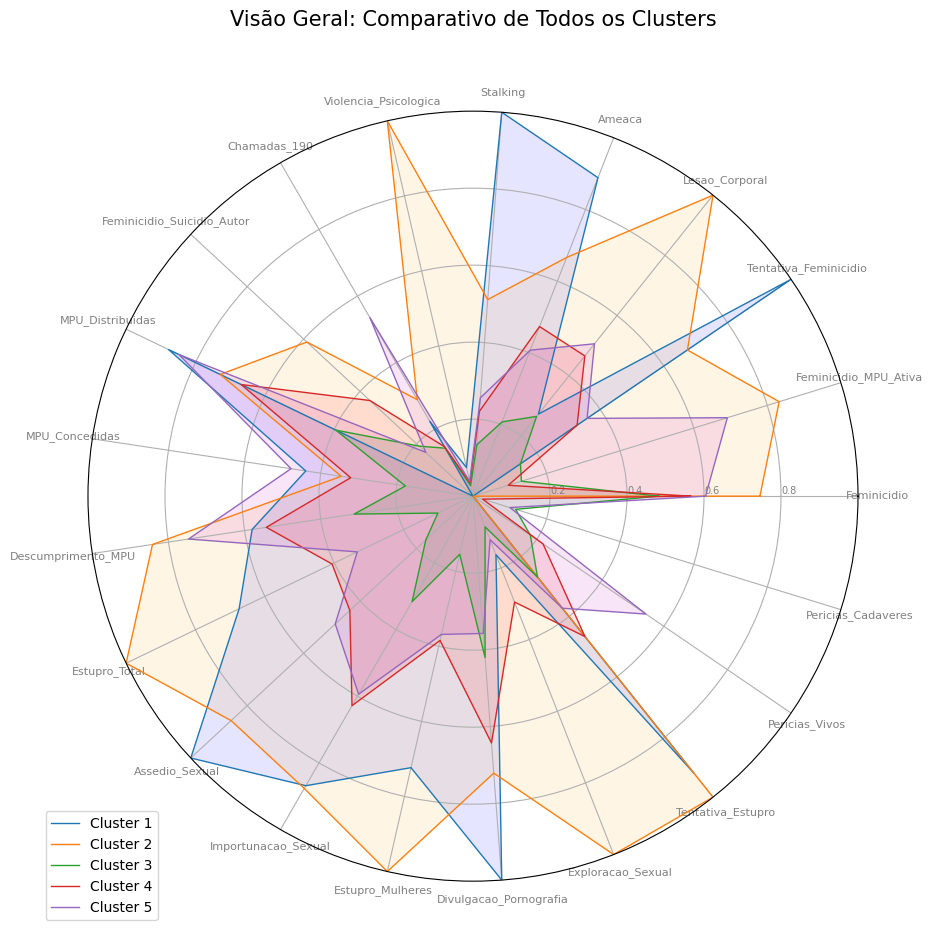

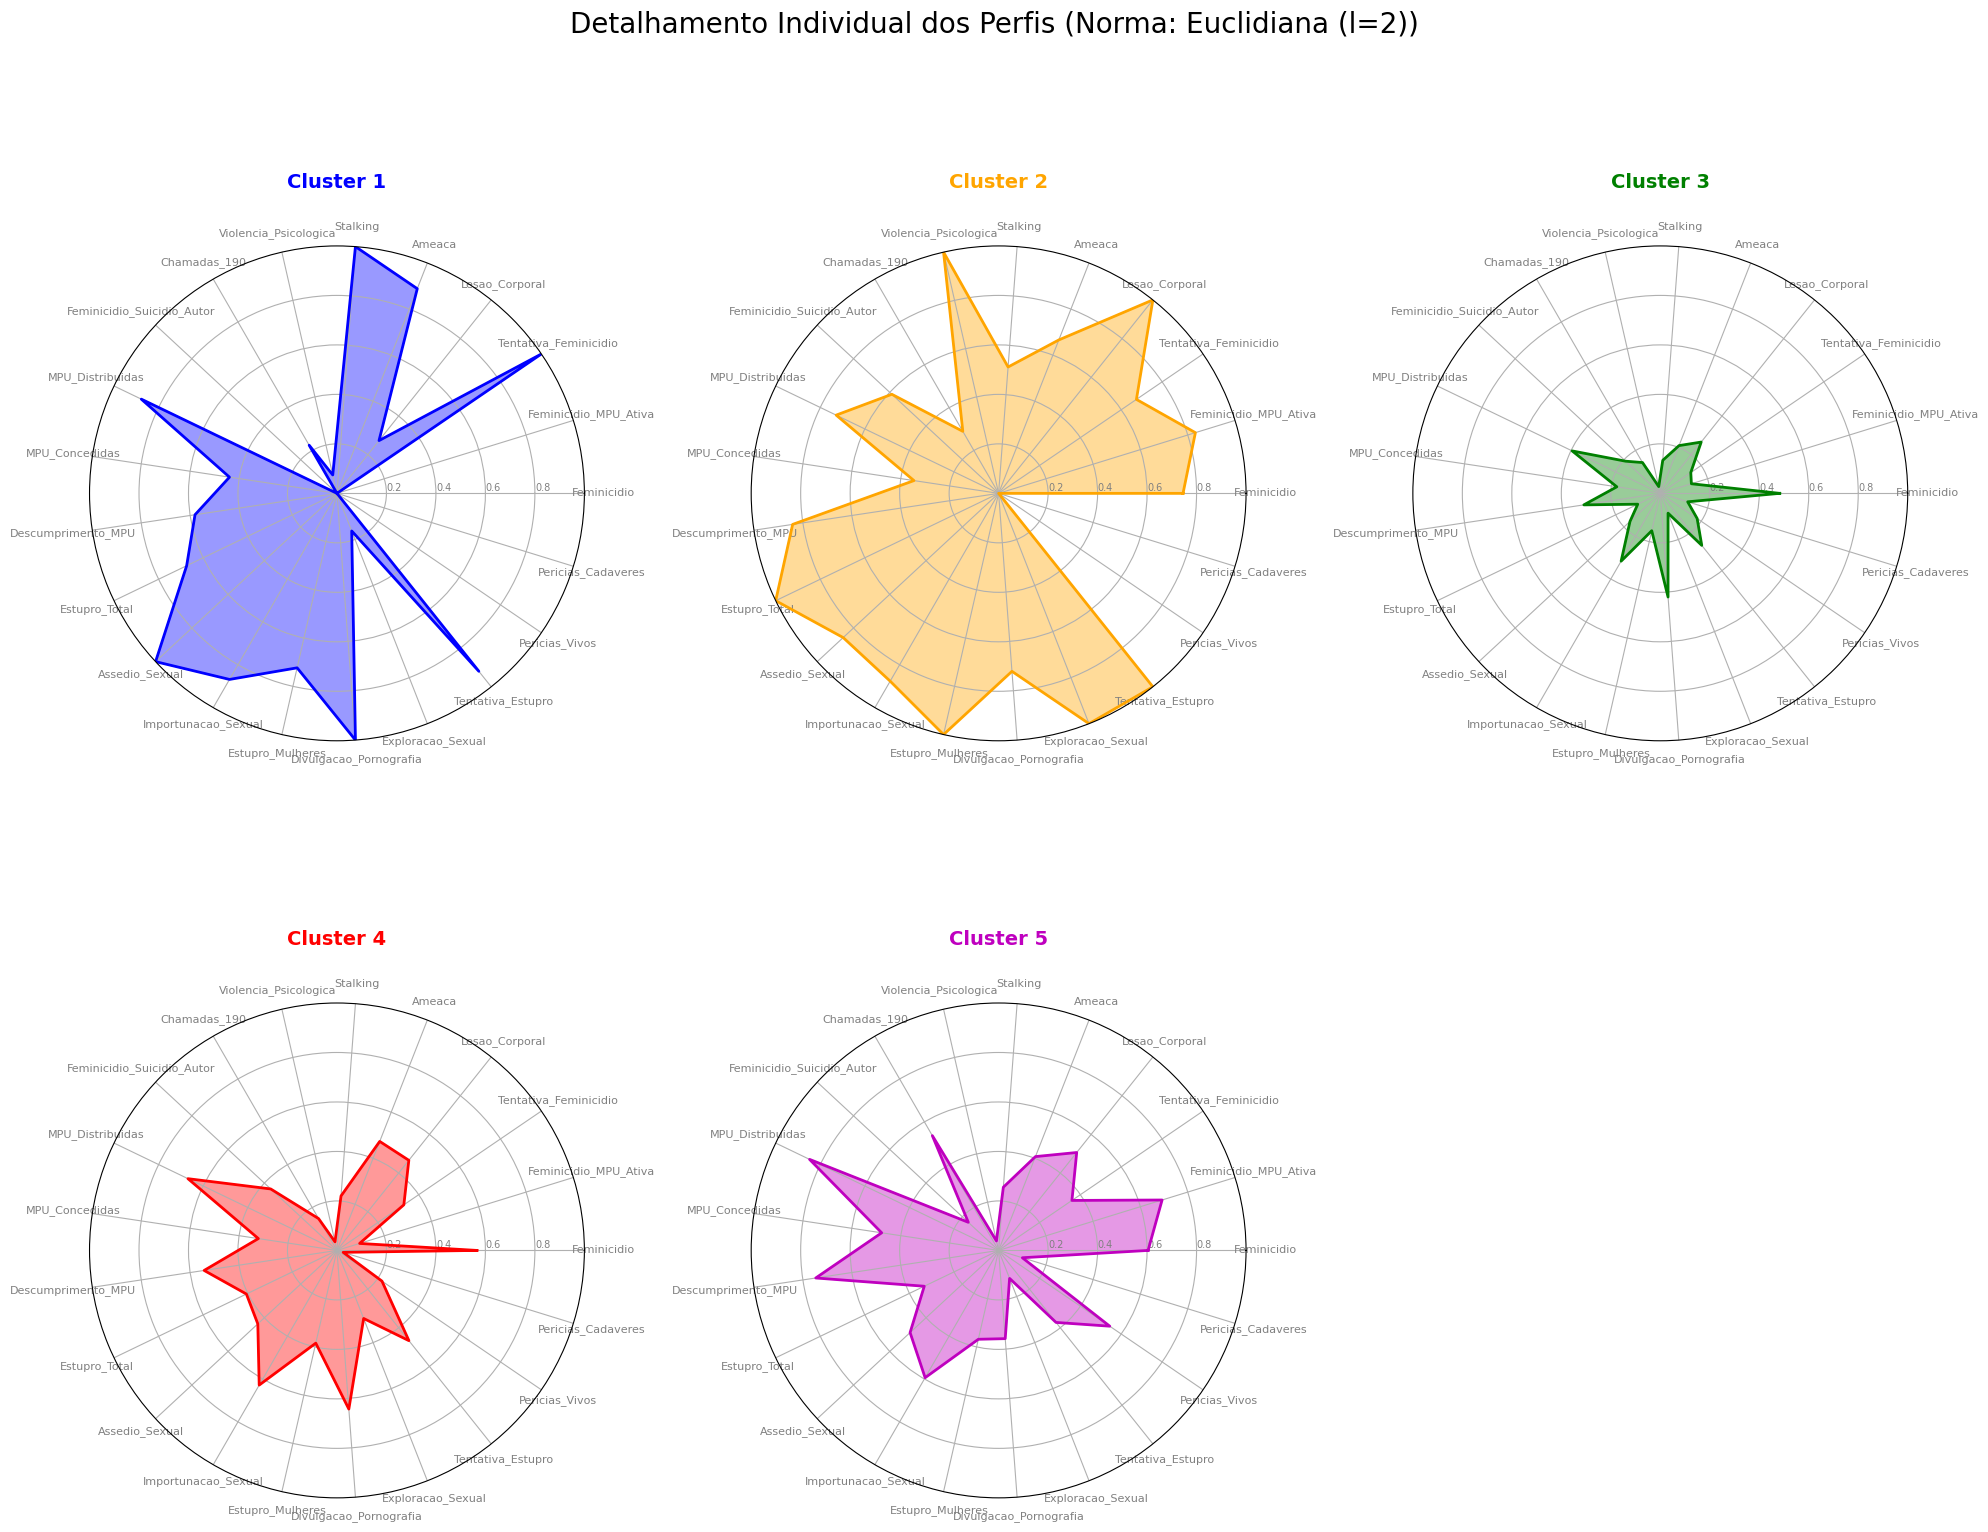

In [13]:
df_viz = df_taxas.copy()
scaler_viz = MinMaxScaler()
cols_numericas = df_viz.select_dtypes(include=[np.number]).columns
df_viz[cols_numericas] = scaler_viz.fit_transform(df_viz[cols_numericas])
df_viz['Cluster'] = melhor_modelo['labels']

perfil_clusters = df_viz.groupby('Cluster').mean()
categorias = list(perfil_clusters.columns)
N = len(categorias)

angulos = [n / float(N) * 2 * pi for n in range(N)]
angulos += angulos[:1] 

cores = ['b', 'orange', 'g', 'r', 'm'] 

# PLOT GERAL
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)
plt.xticks(angulos[:-1], categorias, size=8, color='grey')
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
plt.ylim(0, 1) # Trava a escala entre 0 e 1

for i, (idx, row) in enumerate(perfil_clusters.iterrows()):
    valores = row.values.flatten().tolist()
    valores += valores[:1] # Fechar o polígono
    
    ax.plot(angulos, valores, linewidth=1, linestyle='solid', label=f'Cluster {idx}')
    ax.fill(angulos, valores, cores[i % len(cores)], alpha=0.1) # Alpha baixo para ver sobreposição

plt.title(f"Visão Geral: Comparativo de Todos os Clusters", size=15, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

# PLOTS INDIVIDUAIS
num_clusters = len(perfil_clusters)
cols = 3
rows = int(np.ceil(num_clusters / cols)) 

fig, axes = plt.subplots(rows, cols, figsize=(20, 8 * rows), subplot_kw={'projection': 'polar'})
axes = axes.flatten() 
for i, (idx, row) in enumerate(perfil_clusters.iterrows()):
    ax = axes[i] 
    valores = row.values.flatten().tolist()
    valores += valores[:1]
    cor_atual = cores[i % len(cores)]

    ax.plot(angulos, valores, linewidth=2, linestyle='solid', color=cor_atual)
    ax.fill(angulos, valores, color=cor_atual, alpha=0.4)
    ax.set_xticks(angulos[:-1])
    ax.set_xticklabels(categorias, size=8, color='grey')
    ax.set_rlabel_position(0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
    ax.set_ylim(0, 1) 
    ax.set_title(f"Cluster {idx}", size=14, y=1.1, color=cor_atual, fontweight='bold')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f"Detalhamento Individual dos Perfis (Norma: {melhor_modelo['nome']})", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

## 9. Redução de Dimensionalidade (PCA)
Utilizamos a Análise de Componentes Principais (PCA) para projetar os dados multidimensionais em um plano 2D. Isso nos ajuda a validar a separação dos clusters visualmente e identificar quais estados estão nas fronteiras entre grupos, além de quantificar quanto da variância dos dados é explicada pelos dois primeiros componentes.

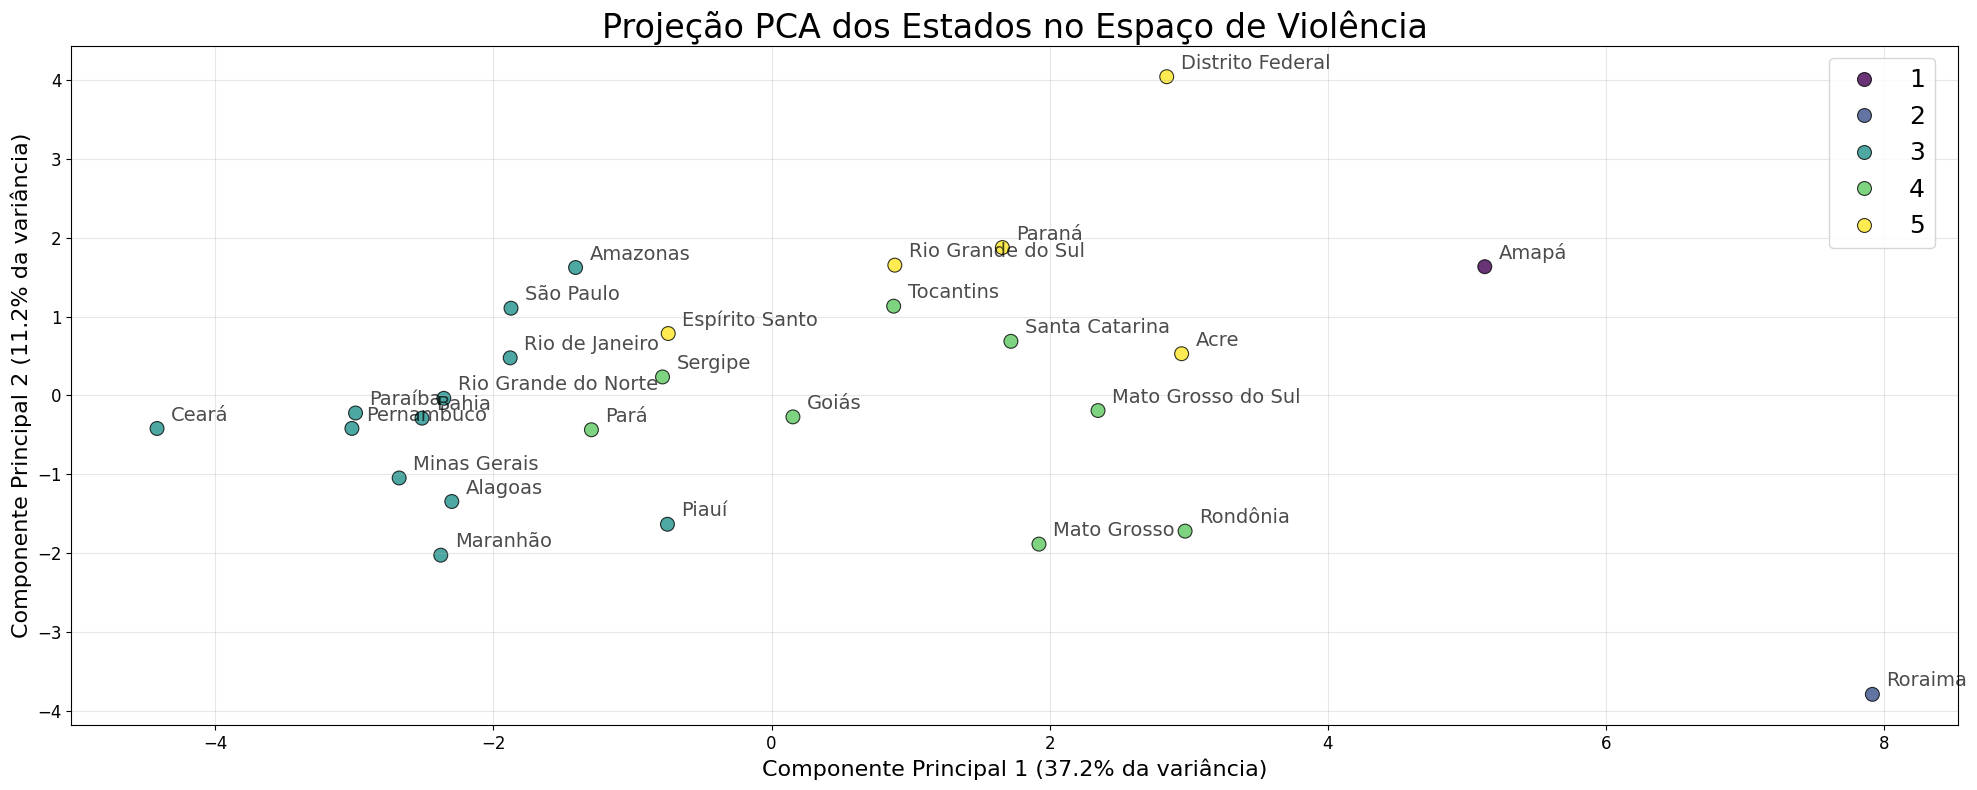

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled) 

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = melhor_modelo['labels']
df_pca['UF'] = df_taxas.index

plt.figure(figsize=(20, 8))
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Cluster', 
    data=df_pca, 
    palette='viridis', 
    s=100, 
    alpha=0.8,
    edgecolor='black'
)

for i in range(df_pca.shape[0]):
    plt.text(
        df_pca.PC1[i]+0.1, 
        df_pca.PC2[i]+0.1, 
        df_pca.UF[i], 
        fontsize=14, 
        alpha=0.7
    )

plt.title(f"Projeção PCA dos Estados no Espaço de Violência", fontsize=24)
plt.xlabel(f"Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} da variância)", fontsize=16)
plt.ylabel(f"Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} da variância)", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(0.925, 1), loc='upper left', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_df = pd.DataFrame(loadings, index=df_taxas.columns, columns=['PC1', 'PC2'])
loading_df['Total'] = loading_df['PC1'].abs() + loading_df['PC2'].abs()
loading_df_sorted_total = loading_df['Total'].sort_values(ascending=False)
print("Top features contributing overall:\n")
print(loading_df_sorted_total)

Top features contributing overall:

Exploracao_Sexual             1.251560
Estupro_Total                 1.179501
MPU_Concedidas                1.157198
MPU_Distribuidas              1.150465
Tentativa_Estupro             1.113201
Importunacao_Sexual           1.110813
Violencia_Psicologica         1.039202
Estupro_Mulheres              0.997257
Stalking                      0.985043
Ameaca                        0.955323
Descumprimento_MPU            0.924605
Tentativa_Feminicidio         0.902058
Assedio_Sexual                0.836358
Lesao_Corporal                0.748596
Feminicidio_Suicidio_Autor    0.680146
Feminicidio                   0.614039
Pericias_Vivos                0.601916
Chamadas_190                  0.592643
Feminicidio_MPU_Ativa         0.552789
Divulgacao_Pornografia        0.540832
Pericias_Cadaveres            0.424293
Name: Total, dtype: float64


## 10. Validação Estatística (Boxplots)
Por fim, analisamos a distribuição de variáveis-chave dentro de cada cluster utilizando Boxplots. Esta visualização ajuda a confirmar se a separação dos grupos é estatisticamente relevante para crimes específicos, mostrando a variância e a presença de outliers.

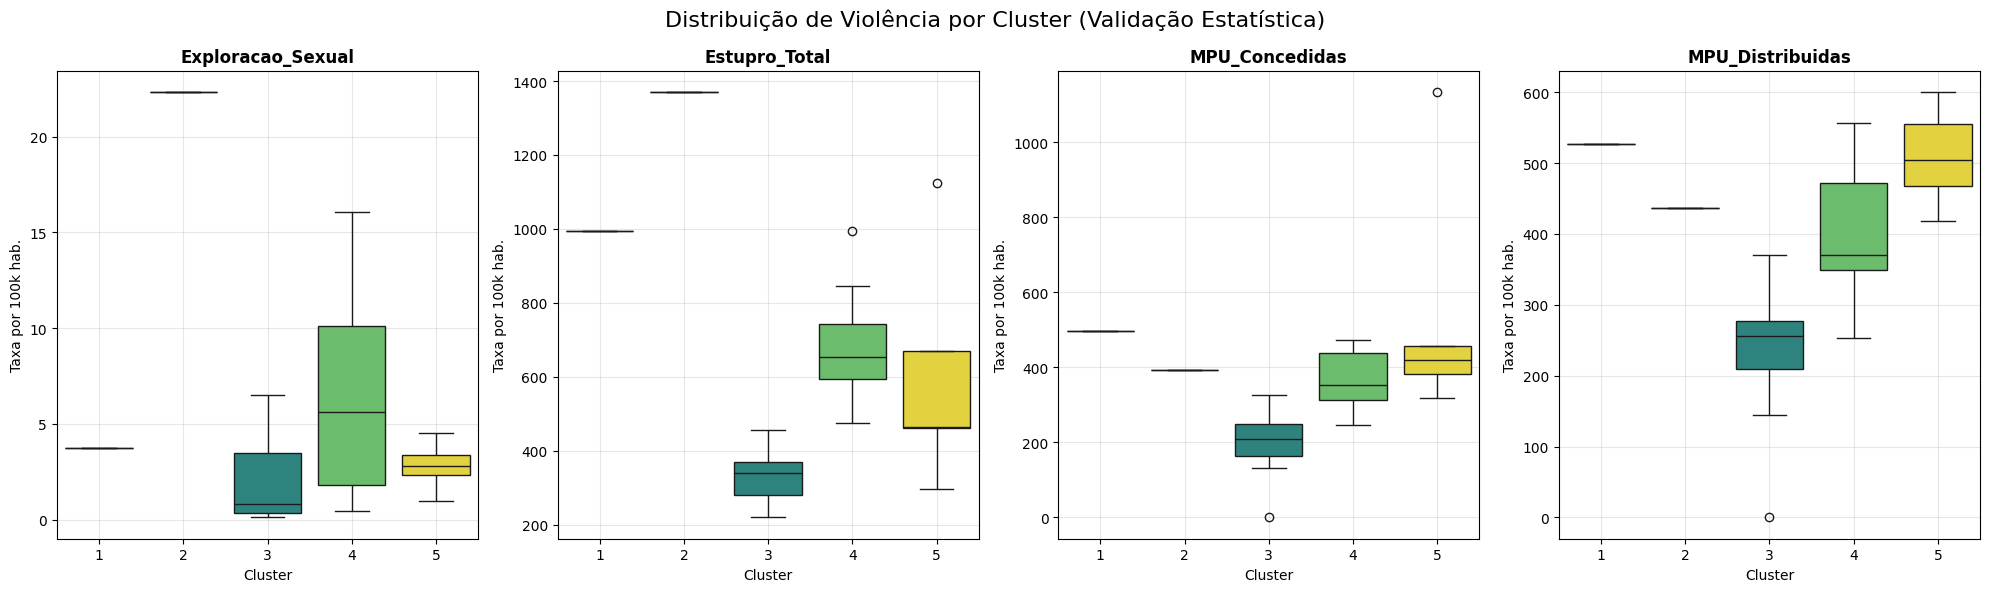

In [16]:
variaveis_foco = ['Exploracao_Sexual', 'Estupro_Total', 'MPU_Concedidas', 'MPU_Distribuidas']

df_box = df_taxas.copy()
df_box['Cluster'] = melhor_modelo['labels']

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle(f"Distribuição de Violência por Cluster (Validação Estatística)", fontsize=16)

for i, col in enumerate(variaveis_foco):
    sns.boxplot(x='Cluster', y=col, data=df_box, ax=axes[i], palette='viridis', hue='Cluster', legend=False)
    axes[i].set_title(col, fontweight='bold')
    axes[i].set_ylabel("Taxa por 100k hab.")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()